Setup

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential


In [ ]:
pip install kaggle
mkdir -p ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
unzip -q ocular-disease-recognition-odir5k.zip

Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [3]:
Dataset_Dir = 'C:\\Users\\duwak\\Desktop\\CS3IP - Individual Project\\Code\\Dataset\\full_df.csv'
df_data = pd.read_csv(Dataset_Dir)
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


Dataset Information

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

Generating the Dataset Images

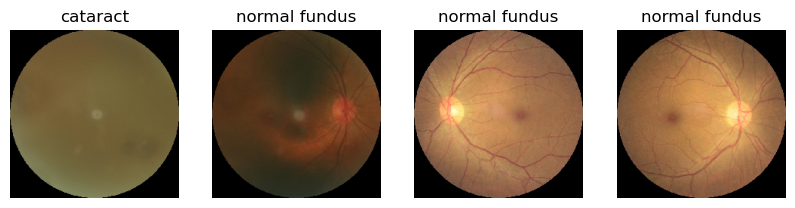

In [14]:
images_path = 'C:\\Users\\duwak\\Desktop\\CS3IP - Individual Project\\Code\\Dataset\\preprocessed_images\\'
images = []
labels = []

for i, row in df_data.iterrows():
    left_image_path = images_path + row['Left-Fundus']
    right_image_path = images_path + row['Right-Fundus'] 

    if os.path.exists(left_image_path):
        left_img = tf.keras.preprocessing.image.load_img(left_image_path, target_size=(224, 224))
        left_img = tf.keras.preprocessing.image.img_to_array(left_img)
        images.append(left_img)
        labels.append(row['Left-Diagnostic Keywords'])

    if os.path.exists(right_image_path):
        right_img = tf.keras.preprocessing.image.load_img(right_image_path, target_size=(224, 224))
        right_img = tf.keras.preprocessing.image.img_to_array(right_img)
        images.append(right_img)
        labels.append(row['Right-Diagnostic Keywords'])

images = np.array(images)

plt.figure(figsize=(10, 10))

for i in range(4): 
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(labels[i])
    plt.axis("off")

plt.show()

Visualising the Fundus Images

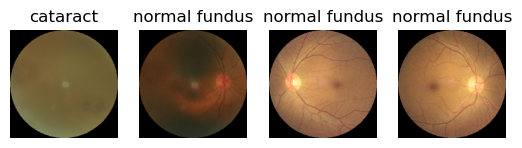

Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H, M, O have low image samples, thus need for balancing these classes is required.

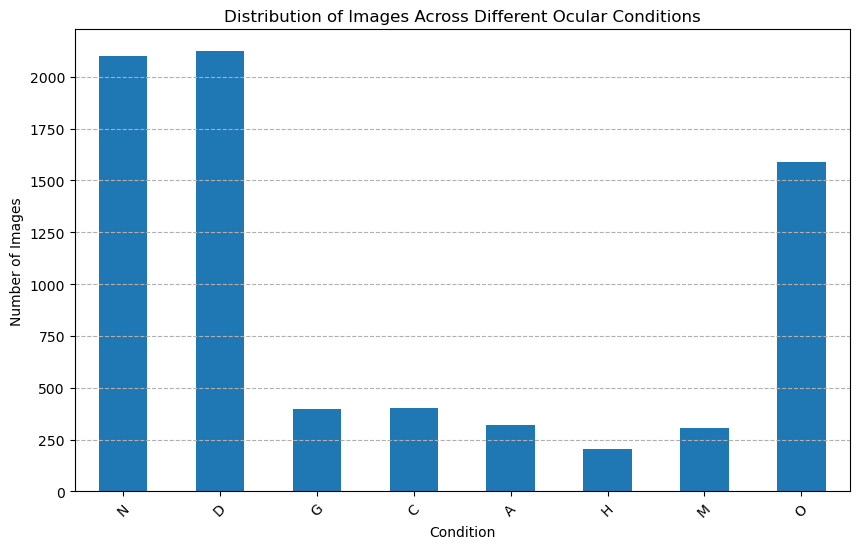

In [7]:
# Sum up the occurrences of each condition
class_counts = df_data[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum()

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

Dealing with class imbalance - Calculating class weights 
- This one approach to resolving the class imbalance, the class weights calculated will make the CNN model more sensitive to underrepresented classes and improve its overall performance on imbalanced datasets. Higher class weight will mean that a single sample from a higher weight class would be considered as 7 samples from a class with lower weights. 


In [8]:
# The dataset is imbalanced, so we will use class weights to balance it out during training                     
total_samples = class_counts.sum()
class_weights = {
    0: total_samples / class_counts[0],
    1: total_samples / class_counts[1],
    2: total_samples / class_counts[2],
    3: total_samples / class_counts[3],
    4: total_samples / class_counts[4],
    5: total_samples / class_counts[5],
    6: total_samples / class_counts[6],
    7: total_samples / class_counts[7]
}       

Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 

In [13]:
# Identify rows belonging to the classes G, C, A, H, M, and O
target_classes = df_data[['G', 'C', 'A', 'H', 'M', 'O']].columns

# Define the augmentation parameters
augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Apply augmentation to the target classes
augmented_images = []
augmented_labels = []

training_data_path = 'C:\\Users\\duwak\\Desktop\\CS3IP - Individual Project\\Code\\Dataset\\ODIR-5K\\Training Im'

for i, row in df_data.iterrows():
    if row['Left-Diagnostic Keywords'] in target_classes:
        left_image_path = training_data_path + row['Left-Fundus']
        if os.path.exists(left_image_path):
            left_img = tf.keras.preprocessing.image.load_img(left_image_path, target_size=(224, 224))
            left_img = tf.keras.preprocessing.image.img_to_array(left_img)
            augmented_images.append(left_img)
            augmented_labels.append(row['Left-Diagnostic Keywords'])
            augmented_images.append(augmentation.random_transform(left_img))
            augmented_labels.append(row['Left-Diagnostic Keywords'])

    if row['Right-Diagnostic Keywords'] in target_classes:
        right_image_path = training_data_path + row['Right-Fundus']
        if os.path.exists(right_image_path):
            right_img = tf.keras.preprocessing.image.load_img(right_image_path, target_size=(224, 224))
            right_img = tf.keras.preprocessing.image.img_to_array(right_img)
            augmented_images.append(right_img)
            augmented_labels.append(row['Right-Diagnostic Keywords'])
            augmented_images.append(augmentation.random_transform(right_img))
            augmented_labels.append(row['Right-Diagnostic Keywords'])

augmented_images = np.array(augmented_images)

if len(augmented_images) > 0:
    plt.imshow(augmented_images[0] / 255.0)  # Normalize if necessary
    plt.title(augmented_labels[0])
    plt.show()
else:
    print("No augmented images")

No augmented images


Improving the efficiency of the dataset
- One-hot encoding for machine learning purposes may not be most efficient for multi-label classification hence to improve the efficiency of this dataset the individual one-hot encoded columns will be converted into a single list also known as multi-hot encoding. 